In [1]:
# Import all the packages

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats
from scipy.stats import skew, norm
from scipy.stats.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoCV, LassoLarsCV, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

# Limit float outputs to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

In [2]:
# Reading the datasets through pandas

test = pd.read_csv('D:/David/Data/HousePrices/test.csv')
train = pd.read_csv('D:/David/Data/HousePrices/train.csv')

In [3]:
# Display the first 5 rows

train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
# Drop and Save the ID column

train_ID = train['Id']
train.drop('Id', axis = 1, inplace = True)
test_ID = test['Id']
test.drop('Id', axis = 1, inplace = True)

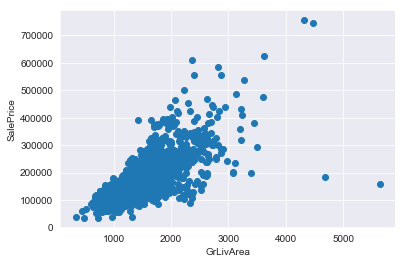

In [5]:
# Creating a scatter-plot

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'],)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

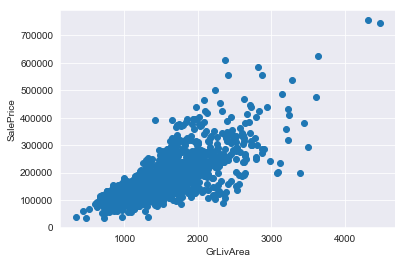

In [6]:
# Drop the outliers

train = train.drop(train[(train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)].index)

# Check the graph again to make sure

fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'],)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()


 mu = 180932.92 and sigma = 79467.79



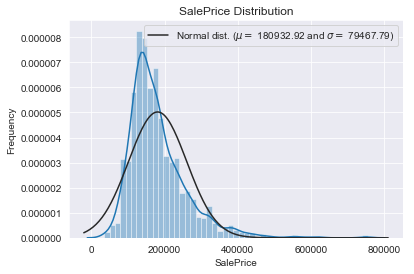

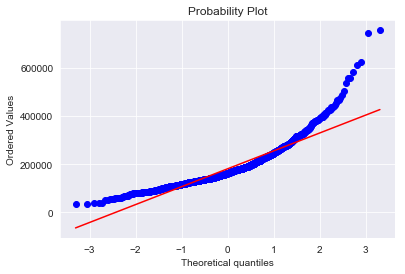

In [7]:
# Creating a distribution plot that contains statistics

sns.distplot(train['SalePrice'], fit = norm);

# Fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Adding a Legend so it looks cool

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc = 'best')
plt.ylabel('Frequency')
plt.xlabel('SalePrice')
plt.title('SalePrice Distribution')

# Formally with QQ-Plot (Probaility Plot) we can determine wether distribution is normal or not
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot = plt)
plt.show()

# For clarity, {:.2f} is a placeholder for text, which the variables are declared later


 mu = 12.02 and sigma = 0.40



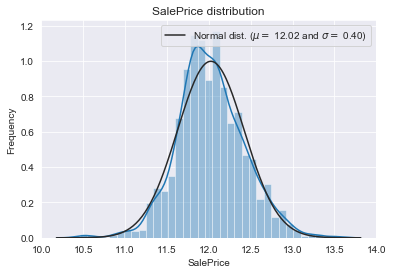

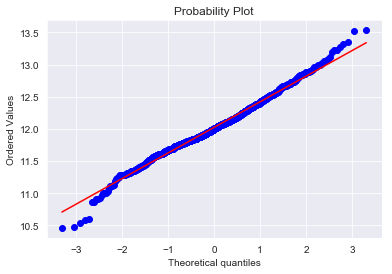

In [8]:
# Taking the log of SalePrice to normalize it

train['SalePrice'] = np.log1p(train['SalePrice'])

# Showing the plot again for clarity

sns.distplot(train['SalePrice'], fit = norm);

# Get the fitted parameters used by the function

(mu, sigma) =  norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Plot the Legend or keys

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})'.format(mu, sigma)], loc = 'best')
plt.ylabel('Frequency')
plt.xlabel('SalePrice')
plt.title('SalePrice distribution')
            
#Get the QQ-Plot (probability plot)
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot = plt)
plt.show()

In [9]:
# Feature Engineering begins

all_data = pd.concat((train, test)).reset_index(drop = True)
all_data.drop(['SalePrice'], axis = 1, inplace = True) # Data to be predicted
print('all_data size is {}'.format(all_data.shape))

y_train = train.SalePrice.values

all_data size is (2917, 79)


In [10]:
# Finding the missing data, and scaling

all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending = False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(25)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageQual,5.451
GarageCond,5.451
GarageFinish,5.451
GarageYrBlt,5.451


Text(0.5,1,'Percent missing data by feature')

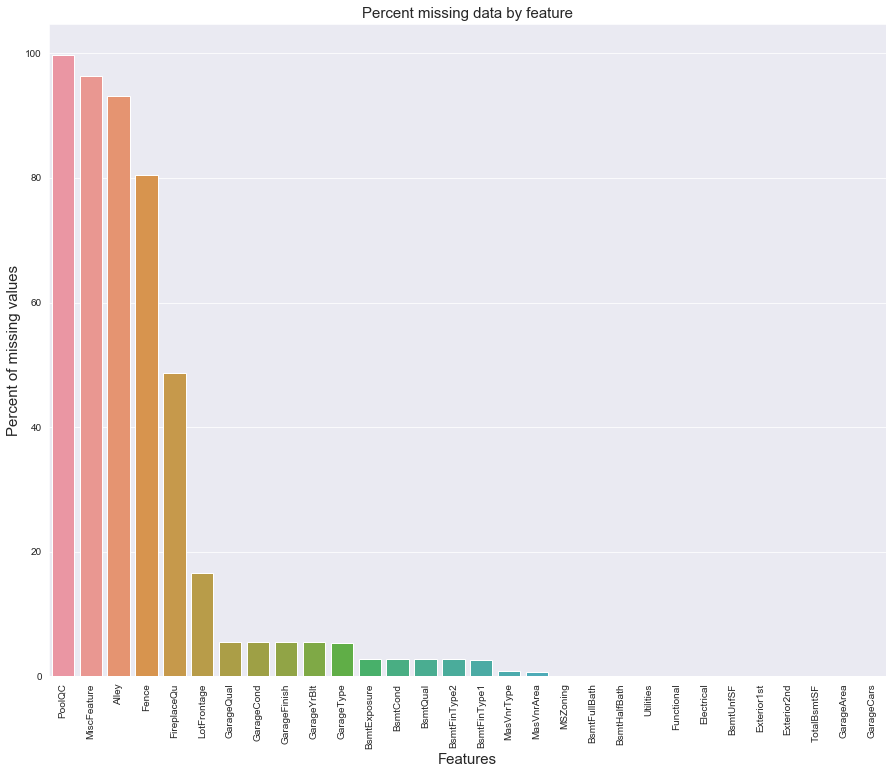

In [11]:
# Plot the distribution of the missing values

f, ax = plt.subplots(figsize = (15, 12))
plt.xticks(rotation = '90')
sns.barplot(x = all_data_na.index, y = all_data_na)
plt.xlabel('Features', fontsize = 15)
plt.ylabel('Percent of missing values', fontsize = 15)
plt.title('Percent missing data by feature', fontsize = 15)

In [12]:
# Filling in categorical missing data

for col in ('MasVnrType', 'MSSubClass', 'GarageType', 'GarageFinish', 'GarageQual',
           'GarageCond', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
           'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna('None')

In [13]:
# Filling in numerical missing data

for col in('MasVnrArea', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1',
          'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

In [14]:
# LotFrontage we're using the median by neighborhood to fill in

all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
lambda x: x.fillna(x.median()))

In [15]:
# MSZoning: since "RL" is the most common value, we use "mode" to input it

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [16]:
# Utilities is quite the same as AllPub, besides a few observations. Remove it

all_data = all_data.drop(['Utilities'], axis = 1)

In [17]:
# Reading the description of the data, NA means typical

all_data['Functional'] = all_data['Functional'].fillna('Typ')

In [18]:
# The rest of these have only 1 or 2 missing data. We will fill it in with the "mode"

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [19]:
# Redisplaying the missing data

all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending = False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


In [20]:
# Formatting our data to I BELIEVE numerical values

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))
    
print('Shape of all_data: {}'.format(all_data.shape))

Shape of all_data: (2917, 78)


In [21]:
# Adding a new feature, Total Square Footage

all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

In [22]:
# Checking for skewness, then correct it

numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

# Skewness

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending = False)
print('\n Skew in numerical features: \n')
skewness = pd.DataFrame({'Skew': skewed_feats})
skewness.head(10)


 Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


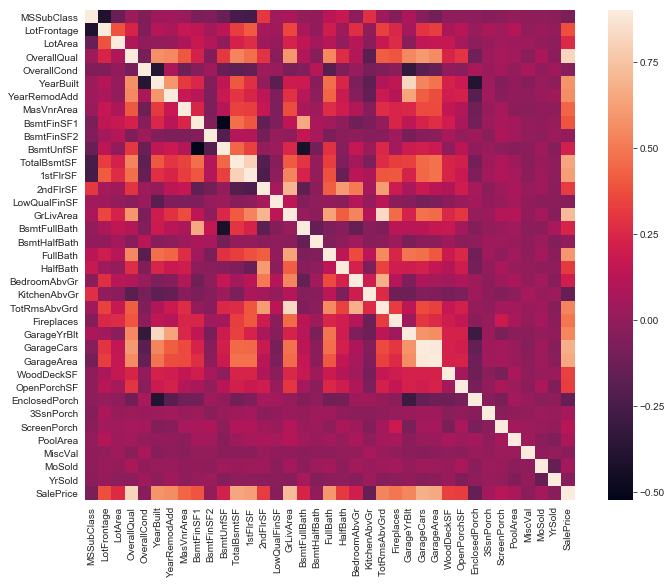

In [23]:
# Correlation Map to see how the features correlate with SalePrice

corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax = 0.9, square = True)

In [24]:
# Correcting skewness with a Box-Cox method

skewness = skewness[abs(skewness) > 0.75]
print('There are {} skewed numerical features to Box Cox transform'.format(skewness.shape[0]))

There are 59 skewed numerical features to Box Cox transform


In [25]:
# Maybe will fix it? We will see. RESULT = I don't know why those two lines are in comments and taking out the comments changed nothing

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)
    
#all_data[skewed_features] = np.log1p(all_data[skewed_features])

In [26]:
# Code the dummies

all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [27]:
# Setting training variables

X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

In [28]:
# Preview of the training data

X_train.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,11.693,11.686,0.000,0.730,1.541,1.820,1.541,11.170,0.000,1.194,...,0,0,0,0,0,0,0,0,0,1
1,12.792,0.000,0.000,0.730,1.541,1.820,0.730,12.063,0.000,0.000,...,0,0,0,0,0,0,0,0,0,1
2,11.892,11.725,0.000,0.730,1.541,1.820,1.194,10.200,0.000,1.194,...,0,0,0,0,0,0,0,0,0,1
3,12.014,11.354,0.000,0.730,1.541,0.730,1.541,8.274,0.000,0.000,...,0,0,0,0,0,0,0,0,0,1
4,12.511,12.271,0.000,0.730,1.820,1.820,0.000,10.971,0.000,1.194,...,0,0,0,0,0,0,0,0,0,1


In [29]:
# Preview of testing data

X_test.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,...,SaleCondition_Partial,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
1458,11.819,0.000,0.000,0.730,1.194,1.820,1.541,10.105,7.397,2.056,...,0,0,0,0,0,0,0,0,0,1
1459,12.944,0.000,0.000,0.730,1.541,1.820,1.541,11.901,0.000,0.000,...,0,0,0,0,0,0,0,0,0,1
1460,11.916,11.151,0.000,0.730,1.541,1.820,1.541,11.477,0.000,1.194,...,0,0,0,0,0,0,0,0,0,1
1461,11.910,11.063,0.000,0.730,1.541,1.820,1.541,10.750,0.000,1.194,...,0,0,0,0,0,0,0,0,0,1
1462,12.834,0.000,0.000,0.730,1.194,1.820,1.541,8.720,0.000,0.000,...,0,0,0,0,0,0,0,0,0,1


In [30]:
# Preview of y (SalePrice) data

y.head()

0   12.248
1   12.109
2   12.317
3   11.849
4   12.429
Name: SalePrice, dtype: float64

In [31]:
# Alright, we're gonna attempt going off the tutorial and mix 2 together and create a K-Fold cross validation

In [32]:
# Using a K-fold Cross Validation method

n_fold = 5

def rmsle_cv(model):
    kf = KFold(n_fold, shuffle = True, random_state = 42).get_n_splits(X_train.values)
    rmse = np.sqrt(-cross_val_score(model, X_train.values, y, scoring = 'neg_mean_squared_error', cv = kf))
    return(rmse)

Text(0,0.5,'rmsle')

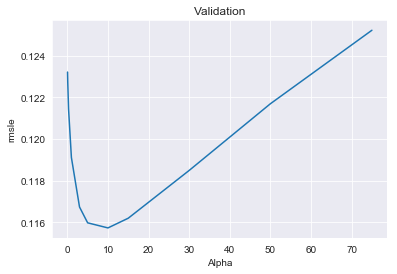

In [33]:
# Creating a Validation model

model_ridge = Ridge()
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmsle_cv(Ridge(alpha = alpha)).mean()
           for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = 'Validation')
plt.xlabel('Alpha')
plt.ylabel('rmsle')

In [34]:
cv_ridge.min()

0.11573567537707134

In [37]:
# Using a Lasso model

lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state = 1))

# Elastic Net Regression

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.0005, l1_ratio = 0.9, random_state = 3))

# Kernel Ridge Regression

KRR = KernelRidge(alpha = 0.6, kernel = 'polynomial', degree = 2, coef0 = 2.5)

# Gradient Boosting Regression

GBoost = GradientBoostingRegressor(n_estimators = 3000, learning_rate = 0.05,
                                  max_depth = 4, max_features = 'sqrt',
                                  min_samples_leaf = 15, min_samples_split = 10,
                                  loss = 'huber', random_state = 5)

# XGBoost

model_xgb = xgb.XGBRegressor(colsample_bytree = 0.4603, gamma = 0.0468,
                            learning_rate = 0.05, max_depth = 3,
                            min_child_weight = 1.7817, n_estimators = 2200,
                            reg_alpha = 0.4640, reg_lambda = 0.8571,
                            subsample = 0.5213, silent = 1, random_state = 7,
                            nthread = -1)

#LightGBM

model_lgb = lgb.LGBMRegressor(objective = 'regression', num_leaves = 5,
                             learning_rate = 0.05, n_estimators = 720,
                             max_bin = 55, bagging_fraction = 0.8,
                             bagging_freq = 5, feature_fraction = 0.2319,
                             feature_fraction_seed = 9, bagging_seed = 9,
                             min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11)

In [38]:
# Scores of each model

score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


Lasso score: 0.1116 (0.0072)

ElasticNet score: 0.1116 (0.0072)

Kernel Ridge score: 0.1153 (0.0071)

Gradient Boosting score: 0.1181 (0.0088)

Xgboost score: 0.1158 (0.0083)

LGBM score: 0.1166 (0.0067)



In [39]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [40]:
# Averaging my scores

averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso,model_xgb,model_lgb))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1088 (0.0072)



In [41]:
# Defining an rmsle evaluation function

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [43]:
# Stacking the models

averaged_models.fit(X_train.values, y)
stacked_train_pred = averaged_models.predict(X_train.values)
stacked_pred = np.expm1(averaged_models.predict(X_test.values))
print(rmsle(y, stacked_train_pred))


model_xgb.fit(X_train, y)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))
print(rmsle(y, xgb_train_pred))


model_lgb.fit(X_train, y)
lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = np.expm1(model_lgb.predict(X_test.values))
print(rmsle(y, lgb_train_pred))


'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

0.07655642637316816
0.08121154151534449
0.07271714810451277
RMSLE score on train data:
0.0753838823873194


In [45]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)

In [ ]:
# End of second testing code